
# Red Lesions Image Labeling from Set 1 -> B (From Masked Image)

In [ ]:

import numpy as np
import os 
import cv2

def generate_label(x):
    if(np.sum(x) > 0):
        return 1
    else:
        return 0  

path ="/Users/madhikm1/Desktop/Dataset_En/Set1/A"

files = []
imgData = []
fNames =[]
labels = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        files.append(os.path.join(r, file))

for f in files:
    frame = cv2.imread(f,1)
    imgData.append(cv2.resize(frame,(320,320)))
    parts = f.split("/")
    fName = parts[len(parts)-1]
    label = generate_label(frame)
    fNames.append(fName)
    labels.append(label)

In [2]:
#for part in fNames:
#    print(part)

#for part in labels:
#    print(part)
    
#for part in imgData:
#    print(part.shape)

# Preparing Training Data

In [31]:
# Preparing Training Data
training_data = []
for i in range (0 , len(imgData)):
    training_data.append([imgData[i],labels[i]])
    



# Suffle Data 

In [32]:
# Suffle Data 
import random
random.shuffle(training_data)
X = []
Y = []
for features_X,label_Y in training_data:
    X.append(features_X)
    Y.append(label_Y)
X = np.array(X).reshape(-1,320,320,3)

# Test for the image No need to Run

1


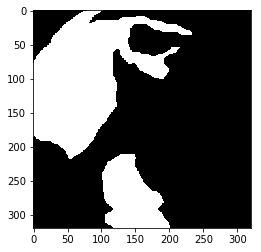

In [93]:
# Test for the image No need to Run
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(X[1])
print(training_data[1][1])

# Model Building

In [34]:
# Model Training 

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten,Conv2D,MaxPooling2D


model = Sequential()

model.add(Conv2D(64,(3,3),input_shape = X.shape[1:]) )
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(64,(3,3),input_shape = X.shape[1:]) )
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Flatten())
model.add(Dense(64))

model.add(Dense(1))
model.add(Activation("sigmoid"))

model.compile(loss="binary_crossentropy",
             optimizer="adam",
             metrics=['accuracy'])

model.fit(X,Y,batch_size=32, epochs=3, validation_split=0.1)

Instructions for updating:
Colocations handled automatically by placer.
Train on 2965 samples, validate on 330 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/3
2965/2965 [==============================] - 2954s 996ms/sample - loss: 0.2144 - acc: 0.9727 - val_loss: 0.1465 - val_acc: 0.9909
Epoch 2/3
2965/2965 [==============================] - 3036s 1s/sample - loss: 0.1740 - acc: 0.9892 - val_loss: 0.1465 - val_acc: 0.9909
Epoch 3/3
2965/2965 [==============================] - 3038s 1s/sample - loss: 0.1740 - acc: 0.9892 - val_loss: 0.1465 - val_acc: 0.9909


# Save Model to disk
## Load the saved model for reuse 
### No training is needed for reuse of model

In [ ]:
# Save Model

from keras.models import load_model  
model.save('my_model.h5') 

# Load Model 
# Uncomment Below code to load model for later Purpose. No need to Train
# ----------------------------------------------------------------------


# model = load_model('my_model.h5')

# Test Image to check bloody or Healthy Image

In [109]:
# Test Image to check bloody or Healthy Image

test_file = "/Users/madhikm1/Desktop/Dataset_En/Set1/B/Set1_668.png"
test_frame = cv2.imread(test_file,1)
test_img = cv2.resize(test_frame,(320,320))
test_img_final = np.array(test_img).reshape(-1,320,320,3)
prediction = model.predict([test_img_final])


    



0


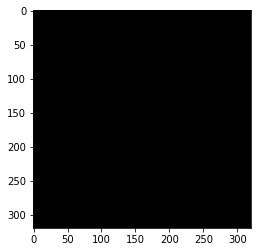

In [110]:
# Print for Predicted Value (1 being Bloody and 0 Being Healthy) 
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt


print(int(prediction[0][0]))
plt.imshow(test_img_final[0])

# Explainable AI using Lime

In [111]:
import lime